# Цели: (все на дизбалансных классах) 
1. Предобработка данных
2. Тестирование решающего дерева, подбор гиперпараметров на cv
3. Тестирование случайного леса, подбор гиперпараметров на cv
4. Тестирование LightGBM, подбро гиперпараметров на cv
5. Тестрование SVM
5. Проверка на метриках AUC, F1-score,  визуализация ROC, PR, подбор threshold'а (порога)

In [ ]:
# P.S. В данном случае мы имеем дело с дизбалансом классов. Помимо выбора подходяшей метрики, возможно использовать (не было сделано):
1. Использовать SMOTE или under-sampling
2. Cost-Sensitive Training (т.е. настроить веса классов так, чтобы они были примерно одинаковы). В случае с lgbm есть параметр class_weight или is_unbalance

In [ ]:
# P.S.S Также в данном случае подбор идет по примитивному GridSearch, лучше использовать optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
#Загрузим датасет
data = pd.read_csv("../input/is-this-a-good-customer/clients.csv")
data.head()

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


In [ ]:
#Посмотрим на info, проверим на пропуски, явные категориальные признаки и т.д.
data.info()

In [4]:
#Посчитаем баланс классов. Видим, что они несбалансированы
data["bad_client_target"].value_counts()

0    1527
1     196
Name: bad_client_target, dtype: int64

In [3]:
#разделим выборку на train и test
from sklearn.model_selection import train_test_split
X = data.iloc[:,:13]
Y = data.iloc[:, 13]


In [4]:
#Разделим с параметром stratify, чтобы в train и test был одинаковый баланс
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 56, shuffle = True, stratify = Y)

In [5]:
#В каждой выборке баланс классов получился 12/88
(Y_train == 1).sum() / (Y_train == 0).sum()

0.12838427947598252

In [8]:
(Y_test == 1).sum() / (Y_test == 0).sum()

0.12827225130890052

In [12]:
#Теперь выделим категориальные признаки.
data.nunique()

month                   12
credit_amount          205
credit_term             22
age                     66
sex                      2
education                6
product_type            22
having_children_flg      2
region                   3
income                  76
family_status            3
phone_operator           5
is_client                2
bad_client_target        2
dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 188.6+ KB


In [5]:
#Заскейлим и закодируем признаки
from sklearn.preprocessing import OneHotEncoder, StandardScaler
categorial = ["month", "sex", "education", "product_type", "having_children_flg", "region", "family_status", "phone_operator", "is_client"]
trainCAT = X_train[categorial]
trainNUM = X_train.drop(categorial, axis = 1)
testCAT = X_test[categorial]
testNUM = X_test.drop(categorial, axis = 1)



In [6]:
ohe = OneHotEncoder()
Scaler = StandardScaler()
trainCAT = ohe.fit_transform(trainCAT)
testCAT = ohe.transform(testCAT)
trainNUM = Scaler.fit_transform(trainNUM)
testNUM = Scaler.transform(testNUM)

In [8]:
X_train = pd.concat([pd.DataFrame(trainCAT.toarray()), pd.DataFrame(trainNUM)], axis = 1, ignore_index = True)
X_test = pd.concat([pd.DataFrame(testCAT.toarray()), pd.DataFrame(testNUM)], axis = 1, ignore_index = True)

In [9]:
Y_train = Y_train.reset_index().drop("index", axis = 1)
Y_test = Y_test.reset_index().drop("index", axis = 1)

In [19]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,9.590050,3.813942,-0.291797,4.079700
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.747247,0.076301,-0.523989,-0.674538
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,-0.729607,-0.858110,0.327381,-0.305276
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,-0.659045,-0.235170,1.565737,-1.043799
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,-0.112192,-0.858110,-0.678784,1.079453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-0.711967,-1.169580,-0.833578,-0.305276
1288,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.606124,-0.858110,-0.833578,-0.951483
1289,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-0.817809,-1.325315,2.107518,-0.859168
1290,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,-0.041630,0.076301,-0.291797,0.479404


In [10]:
#т.к. есть дисбаланс классов будем фолдить по stratified
from sklearn.model_selection import StratifiedKFold
strKFOLD = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 5)


In [11]:
#Обучим простенькое дерево без гиперпараметров
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score
score_f1 = []
score_roc = []
models = []
for fold, (train_idx, val_idx) in enumerate(strKFOLD.split(X_train, Y_train)):
    model = DecisionTreeClassifier(random_state = 55)
    model.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx])
    preds = model.predict(X_train.iloc[val_idx])
    score_f1.append(f1_score(Y_train.iloc[val_idx], preds))
    score_roc.append(roc_auc_score(Y_train.iloc[val_idx], preds))
    models.append(model)
    

In [13]:
#Результат получился слабым, близким к случайному угадыванию
print(f"average f1-score is {sum(score_f1) / 4}, average roc score is {sum(score_roc) / 4}")

average f1-score is 0.26380815222134935, average roc score is 0.5827838754668023


In [ ]:
#Изобразим roc кривую, видим, что нет смысла даже пытатся подбирать threshold.
import scikitplot as skplt
skplt.metrics.plot_roc(Y_train.iloc[val_idx] ,models[3].predict_proba(X_train.iloc[val_idx]))

<AxesSubplot:>

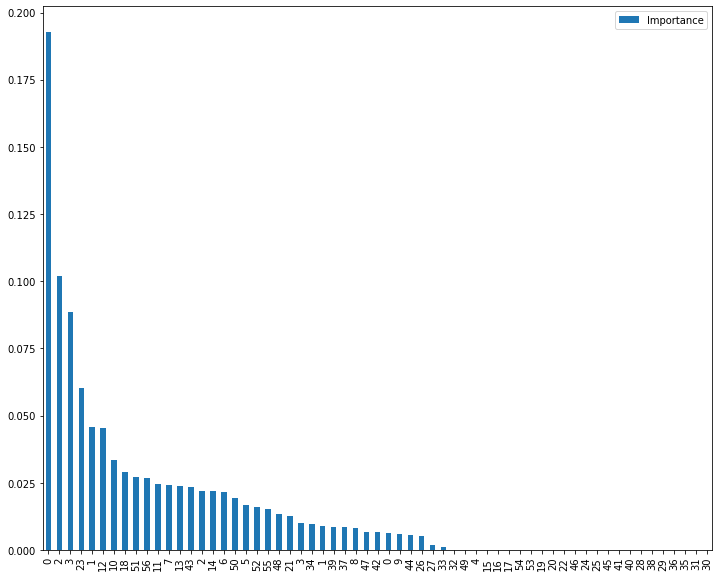

In [28]:
#Важность признаков в одной из моделей.
feat_importances = pd.DataFrame(models[3].feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,10))

In [15]:
#Теперь попробуем поподбирать гиперпараметры на cv
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
params = { "max_depth": [10, 15, 20, 25, 40, 60],
         "max_features" : [None, "sqrt"],
         "random_state": [5],
         "max_leaf_nodes": [None, 15, 30, 50, 60, 100]}
grid = GridSearchCV(model, params, scoring = "roc_auc", cv = 5, verbose = 3)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=None, random_state=5;, score=0.637 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=None, random_state=5;, score=0.628 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=None, random_state=5;, score=0.601 total time=   0.0s
[CV 4/5] END max_depth=10, max_features=None, max_leaf_nodes=None, random_state=5;, score=0.557 total time=   0.0s
[CV 5/5] END max_depth=10, max_features=None, max_leaf_nodes=None, random_state=5;, score=0.555 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=15, random_state=5;, score=0.699 total time=   0.0s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=15, random_state=5;, score=0.665 total time=   0.0s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=15, random_state=5;, score=0.627 total time=   0.0s
[CV 4/5] END max_depth=1

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 15, 20, 25, 40, 60],
                         'max_features': [None, 'sqrt'],
                         'max_leaf_nodes': [None, 15, 30, 50, 60, 100],
                         'random_state': [5]},
             scoring='roc_auc', verbose=3)

In [16]:
#лучшее значение auc roc = 0.67
grid.best_score_

0.6721422476534659

In [17]:
#лучшая модель
grid.best_estimator_

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=15, random_state=5)

In [18]:
#лучшие параметры
grid.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 15,
 'random_state': 5}

In [19]:
#Теперь RandomForest
from sklearn.ensemble import RandomForestClassifier
params = {"n_estimators": [100, 450, 1000],
         "max_depth": [None, 10, 15],
         "max_leaf_nodes": [None, 10, 15, 20, 40],
         "random_state": [55],
         "min_samples_split": [2, 4, 8, 16]}
model = RandomForestClassifier()
grid = GridSearchCV(model, params, scoring = "roc_auc", cv = 5)
grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 15],
                         'max_leaf_nodes': [None, 10, 15, 20, 40],
                         'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [100, 450, 1000],
                         'random_state': [55]},
             scoring='roc_auc')

In [21]:
#Результат лучше
grid.best_score_

0.7438116749485519

In [22]:
#можно попробовать увеличить n_estimators и max_depth
grid.best_params_

{'max_depth': 15,
 'max_leaf_nodes': 20,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'random_state': 55}

In [23]:
from sklearn.ensemble import RandomForestClassifier
params = {"n_estimators": [1000, 1500, 2000],
         "max_depth": [None, 15, 20],
         "max_leaf_nodes": [20, 40],
         "random_state": [55],
         "min_samples_split": [2, 4]}
model = RandomForestClassifier()
grid = GridSearchCV(model, params, scoring = "roc_auc", cv = 5)
grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 15, 20],
                         'max_leaf_nodes': [20, 40],
                         'min_samples_split': [2, 4],
                         'n_estimators': [1000, 1500, 2000],
                         'random_state': [55]},
             scoring='roc_auc')

In [24]:
#Посмотрим, повлияло ли это на качество
grid.best_score_

0.7438116749485519

In [25]:
#Не особо
grid.best_params_

{'max_depth': 15,
 'max_leaf_nodes': 20,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'random_state': 55}

In [13]:
#LightGBM на CV
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm


params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'auc'},
            'subsample': 0.8,
            'subsample_freq': 1,
            'learning_rate': 0.01,
            'num_leaves': 20,
            'feature_fraction': 0.8,
            'lambda_l1': 0.1,  
            "random_state": 62,
            "verbose": -1}

folds = 5
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
for (train_index, val_index) in kf.split(X_train, Y_train):
    lgb_train = lgb.Dataset(X_train.iloc[train_index], Y_train.iloc[train_index])
    lgb_eval = lgb.Dataset(X_train.iloc[val_index], Y_train.iloc[val_index])
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval), early_stopping_rounds = 50, verbose_eval = 10)
    models.append(gbm)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.88093	valid_1's auc: 0.772489
[20]	training's auc: 0.897427	valid_1's auc: 0.771397
[30]	training's auc: 0.903538	valid_1's auc: 0.775546
[40]	training's auc: 0.910032	valid_1's auc: 0.778603
[50]	training's auc: 0.91537	valid_1's auc: 0.778894
Early stopping, best iteration is:
[1]	training's auc: 0.803293	valid_1's auc: 0.792722
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.871888	valid_1's auc: 0.769651
[20]	training's auc: 0.897991	valid_1's auc: 0.783988
[30]	training's auc: 0.899437	valid_1's auc: 0.79214
[40]	training's auc: 0.904924	valid_1's auc: 0.794178
[50]	training's auc: 0.908721	valid_1's auc: 0.789083
[60]	training's auc: 0.912043	valid_1's auc: 0.790393
[70]	training's auc: 0.918206	valid_1's auc: 0.787773
Early stopping, best iteration is:
[26]	training's auc: 0.898336	valid_1's auc: 0.797234
Training until validation scores don't improve for 50 ro

In [41]:
#Теперь посчитаем средний score по всем фолдам.
avg_score_cv = []
for i in range(len(models)):
    avg_score_cv.append(models[i].best_score.get("valid_1").get("auc"))
print(f"Mean AUC score for 5 folds is {np.mean(avg_score_cv)}")

Mean AUC score for 5 folds is 0.7579250112934799


In [ ]:
#тут был поиск по gridsearchCV. Удалил случайно, best_score получил так.

In [63]:
grid.best_score_

0.7476946120238803

In [64]:
grid.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'metric': 'auc',
 'min_child_samples': 140,
 'n_estimators': 50,
 'num_leaves': 5,
 'objective': 'binary',
 'random_state': 62,
 'reg_alpha': 1.2,
 'subsample': 0.8,
 'subsample_freq': 1}

In [73]:
#Смотрим на работу с данными гиперпараметрами
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm


params = grid.best_params_
params["verbose"] = -1
params["n_estimators"] = 500

folds = 5
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
for (train_index, val_index) in kf.split(X_train, Y_train):
    lgb_train = lgb.Dataset(X_train.iloc[train_index], Y_train.iloc[train_index])
    lgb_eval = lgb.Dataset(X_train.iloc[val_index], Y_train.iloc[val_index])
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval), early_stopping_rounds = 50, verbose_eval = 10)
    models.append(gbm)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.765419	valid_1's auc: 0.809534
[20]	training's auc: 0.785886	valid_1's auc: 0.812737
[30]	training's auc: 0.794396	valid_1's auc: 0.806114
[40]	training's auc: 0.808518	valid_1's auc: 0.808515
[50]	training's auc: 0.815171	valid_1's auc: 0.806114
[60]	training's auc: 0.821511	valid_1's auc: 0.800509
Early stopping, best iteration is:
[15]	training's auc: 0.778799	valid_1's auc: 0.814847
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.755916	valid_1's auc: 0.760626
[20]	training's auc: 0.777437	valid_1's auc: 0.802183
[30]	training's auc: 0.793113	valid_1's auc: 0.816376
[40]	training's auc: 0.803745	valid_1's auc: 0.821543
[50]	training's auc: 0.813249	valid_1's auc: 0.828239
[60]	training's auc: 0.823433	valid_1's auc: 0.832751
[70]	training's auc: 0.829414	valid_1's auc: 0.829403
[80]	training's auc: 0.834145	valid_1's auc: 0.831441
[90]	training's auc: 0.837094	val

In [74]:
#AUC повысился незначительно
avg_score_cv = []
for i in range(len(models)):
    avg_score_cv.append(models[i].best_score.get("valid_1").get("auc"))
print(f"Mean AUC score for 5 folds is {np.mean(avg_score_cv)}")

Mean AUC score for 5 folds is 0.7613973799126639


In [75]:
#Проверим SVM
from sklearn.svm import SVC
model = SVC()
from sklearn.model_selection import GridSearchCV
parametrs = { 'kernel': ["linear", "poly", "rbf", "sigmoid"],
              'degree': [3, 4, 6, 15],
              'C': [1.0, 0.95, 0.9] }
grid = GridSearchCV(model, parametrs, cv=5, scoring = "roc_auc")
grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1.0, 0.95, 0.9], 'degree': [3, 4, 6, 15],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc')

In [76]:
#Результат хуже
grid.best_score_

0.6565928825980023

In [99]:
#Проверим качество итоговой модели - градиентный бустинг с лучшими параметрами. 
#Попробуем 2 варианта: наши 5 моделей по фолдам кросс валидации и 1 обученная на всей выборке
preds = np.zeros(shape = (431,))
from sklearn.metrics import f1_score, roc_auc_score
for model in models:
    preds += model.predict(X_test)
preds = preds / 5
    

In [115]:
roc_auc_score(Y_test, preds)

0.7561171065284753

In [117]:
preds.shape

(431,)

In [118]:
Y_test.values.shape

(431, 1)

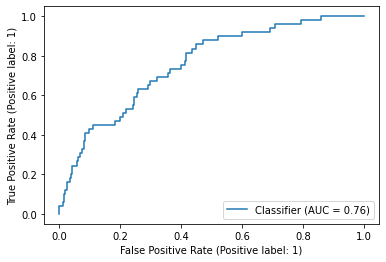

In [121]:
#roc curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(Y_test, preds)
plt.show()

Best Threshold=0.102781, G-Mean=0.690


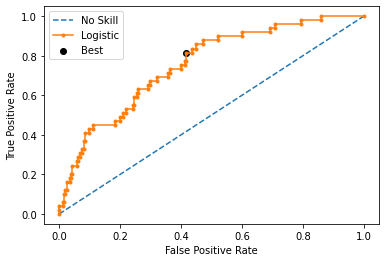

In [131]:
#Лучший threshold (на основе геометрического среднего)
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Y_test, preds)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [132]:
preds[preds > 0.102781] = 1
preds[preds <= 0.102781] = 0
print(preds)

[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.

In [136]:
Y_test

,bad_client_target
0,0
1,0
2,0
3,0
4,0
...,...
426,0
427,1
428,0
429,0


In [139]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy_score(Y_test, preds)

0.6102088167053364

In [140]:
recall_score(Y_test, preds)

0.8163265306122449

In [141]:
precision_score(Y_test, preds)

0.20100502512562815

In [142]:
f1_score(Y_test, preds)

0.32258064516129037

In [126]:
tpr

array([0.        , 0.02040816, 0.04081633, 0.04081633, 0.06122449,
       0.06122449, 0.10204082, 0.10204082, 0.12244898, 0.12244898,
       0.16326531, 0.16326531, 0.18367347, 0.18367347, 0.20408163,
       0.20408163, 0.24489796, 0.24489796, 0.26530612, 0.26530612,
       0.28571429, 0.28571429, 0.30612245, 0.30612245, 0.32653061,
       0.32653061, 0.36734694, 0.36734694, 0.40816327, 0.40816327,
       0.42857143, 0.42857143, 0.44897959, 0.44897959, 0.46938776,
       0.46938776, 0.48979592, 0.48979592, 0.51020408, 0.51020408,
       0.53061224, 0.53061224, 0.55102041, 0.55102041, 0.59183673,
       0.59183673, 0.6122449 , 0.6122449 , 0.63265306, 0.63265306,
       0.65306122, 0.65306122, 0.67346939, 0.67346939, 0.69387755,
       0.69387755, 0.71428571, 0.71428571, 0.73469388, 0.73469388,
       0.75510204, 0.75510204, 0.7755102 , 0.7755102 , 0.81632653,
       0.81632653, 0.83673469, 0.83673469, 0.85714286, 0.85714286,
       0.87755102, 0.87755102, 0.89795918, 0.89795918, 0.91836